In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install mmcv-full -f https://download.openmmlab.com/mmcv/dist/cu111/torch1.10.0/index.html
!git clone https://github.com/open-mmlab/mmsegmentation.git

Looking in links: https://download.openmmlab.com/mmcv/dist/cu111/torch1.10.0/index.html
fatal: destination path 'mmsegmentation' already exists and is not an empty directory.


In [3]:
import torch

print(f"Setup complete. Using torch {torch.__version__} ({torch.cuda.get_device_properties(0).name if torch.cuda.is_available() else 'CPU'})")

Setup complete. Using torch 1.11.0+cu113 (Tesla P100-PCIE-16GB)


In [4]:
%cd mmsegmentation

/content/mmsegmentation


In [5]:
from mmseg.apis import inference_segmentor, init_segmentor, show_result_pyplot
import mmcv

In [6]:
import os.path as osp
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

In [7]:
!mkdir checkpoints
!wget -O //content/mmsegmentation/checkpoints/fpn_r101_512x1024_80k_cityscapes_20200717_012416-c5800d4c.pth https://download.openmmlab.com/mmsegmentation/v0.5/sem_fpn/fpn_r101_512x1024_80k_cityscapes/fpn_r101_512x1024_80k_cityscapes_20200717_012416-c5800d4c.pth

mkdir: cannot create directory ‘checkpoints’: File exists
--2022-04-29 04:21:13--  https://download.openmmlab.com/mmsegmentation/v0.5/sem_fpn/fpn_r101_512x1024_80k_cityscapes/fpn_r101_512x1024_80k_cityscapes_20200717_012416-c5800d4c.pth
Resolving download.openmmlab.com (download.openmmlab.com)... 47.252.96.28
Connecting to download.openmmlab.com (download.openmmlab.com)|47.252.96.28|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 190509585 (182M) [application/octet-stream]
Saving to: ‘//content/mmsegmentation/checkpoints/fpn_r101_512x1024_80k_cityscapes_20200717_012416-c5800d4c.pth’

//content/mmsegment 100%[===================>] 181.68M  8.47MB/s    in 22s     

2022-04-29 04:21:36 (8.28 MB/s) - ‘//content/mmsegmentation/checkpoints/fpn_r101_512x1024_80k_cityscapes_20200717_012416-c5800d4c.pth’ saved [190509585/190509585]



In [8]:
from mmseg.datasets.builder import DATASETS
from mmseg.datasets.custom import CustomDataset

classes = ('background', 'building', 'road')
palette = [[0, 0, 0], [128, 128, 0], [128, 64, 128]]

@DATASETS.register_module()
class SIADataset(CustomDataset):
  CLASSES = classes
  PALETTE = palette
  def __init__(self, split, **kwargs):
    super().__init__(img_suffix='.png', seg_map_suffix='.png', 
                     split=split, **kwargs)
    assert osp.exists(self.img_dir) and self.split is not None

In [9]:
# config 파일을 설정하고, 다운로드 받은 pretrained 모델을 checkpoint로 설정. 
config_file = '/content/mmsegmentation/configs/sem_fpn/fpn_r101_512x1024_80k_cityscapes.py'
checkpoint_file = '/content/mmsegmentation/checkpoints/fpn_r101_512x1024_80k_cityscapes_20200717_012416-c5800d4c.pth'

from mmcv import Config

cfg = Config.fromfile(config_file)
print(cfg.pretty_text)

norm_cfg = dict(type='SyncBN', requires_grad=True)
model = dict(
    type='EncoderDecoder',
    pretrained='open-mmlab://resnet101_v1c',
    backbone=dict(
        type='ResNetV1c',
        depth=101,
        num_stages=4,
        out_indices=(0, 1, 2, 3),
        dilations=(1, 1, 1, 1),
        strides=(1, 2, 2, 2),
        norm_cfg=dict(type='SyncBN', requires_grad=True),
        norm_eval=False,
        style='pytorch',
        contract_dilation=True),
    neck=dict(
        type='FPN',
        in_channels=[256, 512, 1024, 2048],
        out_channels=256,
        num_outs=4),
    decode_head=dict(
        type='FPNHead',
        in_channels=[256, 256, 256, 256],
        in_index=[0, 1, 2, 3],
        feature_strides=[4, 8, 16, 32],
        channels=128,
        dropout_ratio=0.1,
        num_classes=19,
        norm_cfg=dict(type='SyncBN', requires_grad=True),
        align_corners=False,
        loss_decode=dict(
            type='CrossEntropyLoss', use_sigmoid=False, loss_weight=1

In [10]:
norm_cfg = dict(type='BN', requires_grad=True)
model = dict(
    type='EncoderDecoder',
    pretrained='open-mmlab://resnet101_v1c',
    backbone=dict(
        type='ResNetV1c',
        depth=101,
        num_stages=4,
        out_indices=(0, 1, 2, 3),
        dilations=(1, 1, 1, 1),
        strides=(1, 2, 2, 2),
        norm_cfg=dict(type='BN', requires_grad=True),
        norm_eval=False,
        style='pytorch',
        contract_dilation=True),
    neck=dict(
        type='FPN',
        in_channels=[256, 512, 1024, 2048],
        out_channels=256,
        num_outs=4),
    decode_head=dict(
        type='FPNHead',
        in_channels=[256, 256, 256, 256],
        in_index=[0, 1, 2, 3],
        feature_strides=[4, 8, 16, 32],
        channels=128,
        dropout_ratio=0.1,
        num_classes=19,
        norm_cfg=dict(type='BN', requires_grad=True),
        align_corners=False,
        loss_decode=dict(
            type='CrossEntropyLoss', use_sigmoid=False, loss_weight=1.0)),
    train_cfg=dict(),
    test_cfg=dict(mode='whole'))
dataset_type = 'CityscapesDataset'
data_root = 'data/cityscapes/'
img_norm_cfg = dict(
    mean=[123.675, 116.28, 103.53], std=[58.395, 57.12, 57.375], to_rgb=True)
crop_size = (512, 1024)
train_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(type='LoadAnnotations'),
    dict(type='Resize', img_scale=(2048, 1024), ratio_range=(0.5, 2.0)),
    dict(type='RandomCrop', crop_size=(512, 1024), cat_max_ratio=0.75),
    dict(type='RandomFlip', prob=0.5),
    dict(type='PhotoMetricDistortion'),
    dict(
        type='Normalize',
        mean=[123.675, 116.28, 103.53],
        std=[58.395, 57.12, 57.375],
        to_rgb=True),
    dict(type='Pad', size=(512, 1024), pad_val=0, seg_pad_val=255),
    dict(type='DefaultFormatBundle'),
    dict(type='Collect', keys=['img', 'gt_semantic_seg'])
]
test_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(
        type='MultiScaleFlipAug',
        img_scale=(2048, 1024),
        flip=False,
        transforms=[
            dict(type='Resize', keep_ratio=True),
            dict(type='RandomFlip'),
            dict(
                type='Normalize',
                mean=[123.675, 116.28, 103.53],
                std=[58.395, 57.12, 57.375],
                to_rgb=True),
            dict(type='ImageToTensor', keys=['img']),
            dict(type='Collect', keys=['img'])
        ])
]
data = dict(
    samples_per_gpu=2,
    workers_per_gpu=2,
    train=dict(
        type='CityscapesDataset',
        data_root='data/cityscapes/',
        img_dir='leftImg8bit/train',
        ann_dir='gtFine/train',
        pipeline=[
            dict(type='LoadImageFromFile'),
            dict(type='LoadAnnotations'),
            dict(
                type='Resize', img_scale=(2048, 1024), ratio_range=(0.5, 2.0)),
            dict(type='RandomCrop', crop_size=(512, 1024), cat_max_ratio=0.75),
            dict(type='RandomFlip', prob=0.5),
            dict(type='PhotoMetricDistortion'),
            dict(
                type='Normalize',
                mean=[123.675, 116.28, 103.53],
                std=[58.395, 57.12, 57.375],
                to_rgb=True),
            dict(type='Pad', size=(512, 1024), pad_val=0, seg_pad_val=255),
            dict(type='DefaultFormatBundle'),
            dict(type='Collect', keys=['img', 'gt_semantic_seg'])
        ]),
    val=dict(
        type='CityscapesDataset',
        data_root='data/cityscapes/',
        img_dir='leftImg8bit/val',
        ann_dir='gtFine/val',
        pipeline=[
            dict(type='LoadImageFromFile'),
            dict(
                type='MultiScaleFlipAug',
                img_scale=(2048, 1024),
                flip=False,
                transforms=[
                    dict(type='Resize', keep_ratio=True),
                    dict(type='RandomFlip'),
                    dict(
                        type='Normalize',
                        mean=[123.675, 116.28, 103.53],
                        std=[58.395, 57.12, 57.375],
                        to_rgb=True),
                    dict(type='ImageToTensor', keys=['img']),
                    dict(type='Collect', keys=['img'])
                ])
        ]),
    test=dict(
        type='CityscapesDataset',
        data_root='data/cityscapes/',
        img_dir='leftImg8bit/val',
        ann_dir='gtFine/val',
        pipeline=[
            dict(type='LoadImageFromFile'),
            dict(
                type='MultiScaleFlipAug',
                img_scale=(2048, 1024),
                flip=False,
                transforms=[
                    dict(type='Resize', keep_ratio=True),
                    dict(type='RandomFlip'),
                    dict(
                        type='Normalize',
                        mean=[123.675, 116.28, 103.53],
                        std=[58.395, 57.12, 57.375],
                        to_rgb=True),
                    dict(type='ImageToTensor', keys=['img']),
                    dict(type='Collect', keys=['img'])
                ])
        ]))
log_config = dict(
    interval=50, hooks=[dict(type='TextLoggerHook', by_epoch=False)])
dist_params = dict(backend='nccl')
log_level = 'INFO'
load_from = None
resume_from = None
workflow = [('train', 1)]
cudnn_benchmark = True
optimizer = dict(type='SGD', lr=0.01, momentum=0.9, weight_decay=0.0005)
optimizer_config = dict()
lr_config = dict(policy='poly', power=0.9, min_lr=0.0001, by_epoch=False)
runner = dict(type='IterBasedRunner', max_iters=80000)
checkpoint_config = dict(by_epoch=False, interval=8000)
evaluation = dict(interval=8000, metric='mIoU', pre_eval=True)

In [11]:
model = dict(
    type='EncoderDecoder',
    pretrained='open-mmlab://resnet101_v1c',
    backbone=dict(
        type='ResNetV1c',
        depth=101,
        num_stages=4,
        out_indices=(0, 1, 2, 3),
        dilations=(1, 1, 1, 1),
        strides=(1, 2, 2, 2),
        norm_cfg=dict(type='BN', requires_grad=True),
        norm_eval=False,
        style='pytorch',
        contract_dilation=True),
    neck=dict(
        type='FPN',
        in_channels=[256, 512, 1024, 2048],
        out_channels=256,
        num_outs=4),
    decode_head=dict(
        type='FPNHead',
        in_channels=[256, 256, 256, 256],
        in_index=[0, 1, 2, 3],
        feature_strides=[4, 8, 16, 32],
        channels=128,
        dropout_ratio=0.1,
        num_classes=19,
        norm_cfg=dict(type='BN', requires_grad=True),
        align_corners=False,
        loss_decode=dict(
            type='CrossEntropyLoss', use_sigmoid=False, loss_weight=1.0)),
    train_cfg=dict(),
    test_cfg=dict(mode='whole'))

In [12]:
img_norm_cfg = dict(
    mean=[123.675, 116.28, 103.53], std=[58.395, 57.12, 57.375], to_rgb=True)
crop_size = (512, 1024)
train_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(type='LoadAnnotations'),
    dict(type='Resize', img_scale=(2048, 1024), ratio_range=(0.5, 2.0)),
    dict(type='RandomCrop', crop_size=(512, 1024), cat_max_ratio=0.75),
    dict(type='RandomFlip', prob=0.5),
    dict(type='PhotoMetricDistortion'),
    dict(
        type='Normalize',
        mean=[123.675, 116.28, 103.53],
        std=[58.395, 57.12, 57.375],
        to_rgb=True),
    dict(type='Pad', size=(512, 1024), pad_val=0, seg_pad_val=255),
    dict(type='DefaultFormatBundle'),
    dict(type='Collect', keys=['img', 'gt_semantic_seg'])
]
test_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(
        type='MultiScaleFlipAug',
        img_scale=(2048, 1024),
        flip=False,
        transforms=[
            dict(type='Resize', keep_ratio=True),
            dict(type='RandomFlip'),
            dict(
                type='Normalize',
                mean=[123.675, 116.28, 103.53],
                std=[58.395, 57.12, 57.375],
                to_rgb=True),
            dict(type='ImageToTensor', keys=['img']),
            dict(type='Collect', keys=['img'])
        ])
]

In [13]:
dataset_type = 'CityscapesDataset'
data_root = 'data/cityscapes/'

data = dict(
    samples_per_gpu=2,  #batch size
    workers_per_gpu=2,  
    train=dict(
        type='CityscapesDataset',
        data_root='data/cityscapes/',
        img_dir='leftImg8bit/train',
        ann_dir='gtFine/train',
        pipeline=[
            dict(type='LoadImageFromFile'),
            dict(type='LoadAnnotations'),
            dict(
                type='Resize', img_scale=(2048, 1024), ratio_range=(0.5, 2.0)),
            dict(type='RandomCrop', crop_size=(512, 1024), cat_max_ratio=0.75),
            dict(type='RandomFlip', prob=0.5),
            dict(type='PhotoMetricDistortion'),
            dict(
                type='Normalize',
                mean=[123.675, 116.28, 103.53],
                std=[58.395, 57.12, 57.375],
                to_rgb=True),
            dict(type='Pad', size=(512, 1024), pad_val=0, seg_pad_val=255),
            dict(type='DefaultFormatBundle'),
            dict(type='Collect', keys=['img', 'gt_semantic_seg'])
        ]),
    val=dict(
        type='CityscapesDataset',
        data_root='data/cityscapes/',
        img_dir='leftImg8bit/val',
        ann_dir='gtFine/val',
        pipeline=[
            dict(type='LoadImageFromFile'),
            dict(
                type='MultiScaleFlipAug',
                img_scale=(2048, 1024),
                flip=False,
                transforms=[
                    dict(type='Resize', keep_ratio=True),
                    dict(type='RandomFlip'),
                    dict(
                        type='Normalize',
                        mean=[123.675, 116.28, 103.53],
                        std=[58.395, 57.12, 57.375],
                        to_rgb=True),
                    dict(type='ImageToTensor', keys=['img']),
                    dict(type='Collect', keys=['img'])
                ])
        ]),
    test=dict(
        type='CityscapesDataset',
        data_root='data/cityscapes/',
        img_dir='leftImg8bit/val',
        ann_dir='gtFine/val',
        pipeline=[
            dict(type='LoadImageFromFile'),
            dict(
                type='MultiScaleFlipAug',
                img_scale=(2048, 1024),
                flip=False,
                transforms=[
                    dict(type='Resize', keep_ratio=True),
                    dict(type='RandomFlip'),
                    dict(
                        type='Normalize',
                        mean=[123.675, 116.28, 103.53],
                        std=[58.395, 57.12, 57.375],
                        to_rgb=True),
                    dict(type='ImageToTensor', keys=['img']),
                    dict(type='Collect', keys=['img'])
                ])
        ]))

In [14]:
cfg.norm_cfg = dict(type='BN', requires_grad=True)
cfg.model.backbone.norm_cfg = cfg.norm_cfg
cfg.model.decode_head.norm_cfg = cfg.norm_cfg

cfg.model.decode_head.num_classes = 3

In [15]:
cfg.img_norm_cfg = dict(
    mean=[123.675, 116.28, 103.53], std=[58.395, 57.12, 57.375], to_rgb=True)
cfg.crop_size = (512, 1024)
cfg.train_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(type='LoadAnnotations'),
    dict(type='Resize', img_scale=(1024, 1024), ratio_range=(0.5, 2.0)),
    dict(type='RandomCrop', crop_size=cfg.crop_size, cat_max_ratio=0.75),
    dict(type='RandomFlip', flip_ratio=0.5),
    dict(type='PhotoMetricDistortion'),
    dict(type='Normalize', **cfg.img_norm_cfg),
    dict(type='Pad', size=cfg.crop_size, pad_val=0, seg_pad_val=255),
    dict(type='DefaultFormatBundle'),
    dict(type='Collect', keys=['img', 'gt_semantic_seg']),
]

cfg.test_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(
        type='MultiScaleFlipAug',
        img_scale=(1024, 1024),
        # img_ratios=[0.5, 0.75, 1.0, 1.25, 1.5, 1.75],
        flip=False,
        transforms=[
            dict(type='Resize', keep_ratio=True),
            dict(type='RandomFlip'),
            dict(type='Normalize', **cfg.img_norm_cfg),
            dict(type='ImageToTensor', keys=['img']),
            dict(type='Collect', keys=['img']),
        ])
]

In [16]:
cfg.dataset_type = 'SIADataset'
cfg.data_root = '/content/drive/MyDrive/SIA'

cfg.data.train.type = 'SIADataset'
cfg.data.train.data_root = '/content/drive/MyDrive/SIA'
cfg.data.train.img_dir = 'images'
cfg.data.train.ann_dir = 'labels'
cfg.data.train.pipeline = cfg.train_pipeline
cfg.data.train.split = 'splits/train.txt'

cfg.data.val.type = 'SIADataset'
cfg.data.val.data_root = '/content/drive/MyDrive/SIA'
cfg.data.val.img_dir = 'images'
cfg.data.val.ann_dir = 'labels'
cfg.data.val.pipeline = cfg.test_pipeline
cfg.data.val.split = 'splits/val.txt'

cfg.data.test.type = 'SIADataset'
cfg.data.test.data_root = '/content/drive/MyDrive/SIA'
cfg.data.test.img_dir = 'images'
cfg.data.test.ann_dir = 'labels'
cfg.data.test.pipeline = cfg.test_pipeline
cfg.data.test.split = 'splits/val.txt'

In [17]:
cfg.data.train.type = 'SIADataset'
cfg.data.train.data_root = '/content/drive/MyDrive/SIA'
cfg.data.train.img_dir = 'images'
cfg.data.train.ann_dir = 'labels'
cfg.data.train.pipeline = cfg.train_pipeline
cfg.data.train.split = 'splits/train.txt'

In [18]:
cfg.load_from = '/content/mmsegmentation/checkpoints/fpn_r101_512x1024_80k_cityscapes_20200717_012416-c5800d4c.pth'

# Set up working dir to save files and logs.
cfg.work_dir = '/content/drive/MyDrive/SIA/semantic_checkpoint'

In [19]:
cfg.runner.max_iteTrs = 200
cfg.log_config.interval = 50
cfg.evaluation.interval = 1000  # 모델 학습시 평가를 몇 번째 iteration마다 할 것인지 지정
cfg.checkpoint_config.interval = 1000  # 모델 학습시 학습한 모델을 몇 번째 iteration마다 저장할 것인지 지정

cfg.runner = dict(type='IterBasedRunner', max_iters=4000)  # Iteration으로 동작, Epoch로 동작하게 변경할 수도 있음
# cfg.runner = dict(type='EpochBasedRunner', max_epochs=4000)  # Epoch로 변경
cfg.workflow = [('train', 1)]

# Set seed to facitate reproducing the result
cfg.seed = 0
#set_random_seed(0, deterministic=False)
cfg.gpu_ids = range(1)

# Let's have a look at the final config used for training
print(f'Config:\n{cfg.pretty_text}')

Config:
norm_cfg = dict(type='BN', requires_grad=True)
model = dict(
    type='EncoderDecoder',
    pretrained='open-mmlab://resnet101_v1c',
    backbone=dict(
        type='ResNetV1c',
        depth=101,
        num_stages=4,
        out_indices=(0, 1, 2, 3),
        dilations=(1, 1, 1, 1),
        strides=(1, 2, 2, 2),
        norm_cfg=dict(type='BN', requires_grad=True),
        norm_eval=False,
        style='pytorch',
        contract_dilation=True),
    neck=dict(
        type='FPN',
        in_channels=[256, 512, 1024, 2048],
        out_channels=256,
        num_outs=4),
    decode_head=dict(
        type='FPNHead',
        in_channels=[256, 256, 256, 256],
        in_index=[0, 1, 2, 3],
        feature_strides=[4, 8, 16, 32],
        channels=128,
        dropout_ratio=0.1,
        num_classes=3,
        norm_cfg=dict(type='BN', requires_grad=True),
        align_corners=False,
        loss_decode=dict(
            type='CrossEntropyLoss', use_sigmoid=False, loss_weight=1.0)),

In [20]:
from mmseg.datasets import build_dataset
from mmseg.models import build_segmentor
from mmseg.apis import train_segmentor

# Build the dataset
datasets = [build_dataset(cfg.data.train)]

# Build the detector
model = build_segmentor(
    cfg.model, train_cfg=cfg.get('train_cfg'), test_cfg=cfg.get('test_cfg'))

# Add an attribute for visualization convenience
model.CLASSES = datasets[0].CLASSES

# Create work_dir
mmcv.mkdir_or_exist(osp.abspath(cfg.work_dir))
train_segmentor(model, datasets, cfg, distributed=False, validate=True,
                meta=dict(CLASSES=classes, PALETTE=palette))

2022-04-29 04:21:37,299 - mmseg - INFO - Loaded 2158 images
/content/mmsegmentation/mmseg/models/backbones/resnet.py:431: UserWarning: DeprecationWarning: pretrained is a deprecated, please use "init_cfg" instead
  warnings.warn('DeprecationWarning: pretrained is a deprecated, '
/content/mmsegmentation/mmseg/models/losses/cross_entropy_loss.py:233: UserWarning: Default ``avg_non_ignore`` is False, if you would like to ignore the certain label and average loss over non-ignore labels, which is the same with PyTorch official cross_entropy, set ``avg_non_ignore=True``.
  'Default ``avg_non_ignore`` is False, if you would like to '
2022-04-29 04:21:41,021 - mmseg - INFO - Loaded 2158 images
2022-04-29 04:21:41,026 - mmseg - INFO - load checkpoint from local path: /content/mmsegmentation/checkpoints/fpn_r101_512x1024_80k_cityscapes_20200717_012416-c5800d4c.pth
2022-04-29 04:21:41,278 - mmseg - WARNING - The model and loaded state dict do not match exactly

size mismatch for decode_head.conv_

[>>>>>>>>>>>>>>>>>>>>>>>>>>>] 2158/2158, 7.1 task/s, elapsed: 302s, ETA:     0s

2022-04-29 04:31:39,630 - mmseg - INFO - per class results:
2022-04-29 04:31:39,632 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 81.07 | 99.42 |
|  building  |  0.31 |  0.32 |
|    road    |  0.0  |  0.0  |
+------------+-------+-------+
2022-04-29 04:31:39,634 - mmseg - INFO - Summary:
2022-04-29 04:31:39,635 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 81.05 | 27.13 | 33.25 |
+-------+-------+-------+
2022-04-29 04:31:39,646 - mmseg - INFO - Iter(val) [2158]	aAcc: 0.8105, mIoU: 0.2713, mAcc: 0.3325, IoU.background: 0.8107, IoU.building: 0.0031, IoU.road: 0.0000, Acc.background: 0.9942, Acc.building: 0.0032, Acc.road: 0.0000
2022-04-29 04:31:54,346 - mmseg - INFO - Iter [1050/4000]	lr: 7.629e-03, eta: 0:28:42, time: 6.340, data_time: 6.052, memory: 3702, decode.loss_ce: 0.5488, decode.acc_seg: 80.4868, loss: 0.5488
2022-04-29 04:32:11,250 - mmseg - INFO

[>>>>>>>>>>>>>>>>>>>>>>>>>>>] 2158/2158, 7.1 task/s, elapsed: 303s, ETA:     0s

2022-04-29 04:41:41,618 - mmseg - INFO - per class results:
2022-04-29 04:41:41,620 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 81.49 | 99.99 |
|  building  |  0.07 |  0.07 |
|    road    |  0.0  |  0.0  |
+------------+-------+-------+
2022-04-29 04:41:41,621 - mmseg - INFO - Summary:
2022-04-29 04:41:41,623 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 81.49 | 27.19 | 33.35 |
+-------+-------+-------+
2022-04-29 04:41:41,628 - mmseg - INFO - Iter(val) [2158]	aAcc: 0.8149, mIoU: 0.2719, mAcc: 0.3335, IoU.background: 0.8149, IoU.building: 0.0007, IoU.road: 0.0000, Acc.background: 0.9999, Acc.building: 0.0007, Acc.road: 0.0000
2022-04-29 04:41:56,322 - mmseg - INFO - Iter [2050/4000]	lr: 5.288e-03, eta: 0:19:15, time: 6.363, data_time: 6.075, memory: 3702, decode.loss_ce: 0.4927, decode.acc_seg: 82.5949, loss: 0.4927
2022-04-29 04:42:10,981 - mmseg - INFO

[>>>>>>>>>>>>>>>>>>>>>>>>>>>] 2158/2158, 7.1 task/s, elapsed: 303s, ETA:     0s

2022-04-29 04:51:42,349 - mmseg - INFO - per class results:
2022-04-29 04:51:42,350 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 80.68 | 98.09 |
|  building  |  0.91 |  0.91 |
|    road    |  9.75 |  12.1 |
+------------+-------+-------+
2022-04-29 04:51:42,352 - mmseg - INFO - Summary:
2022-04-29 04:51:42,353 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 80.81 | 30.45 | 37.03 |
+-------+-------+-------+
2022-04-29 04:51:42,360 - mmseg - INFO - Iter(val) [2158]	aAcc: 0.8081, mIoU: 0.3045, mAcc: 0.3703, IoU.background: 0.8068, IoU.building: 0.0091, IoU.road: 0.0975, Acc.background: 0.9809, Acc.building: 0.0091, Acc.road: 0.1210
2022-04-29 04:51:57,051 - mmseg - INFO - Iter [3050/4000]	lr: 2.817e-03, eta: 0:09:25, time: 6.348, data_time: 6.060, memory: 3702, decode.loss_ce: 0.4884, decode.acc_seg: 79.2113, loss: 0.4884
2022-04-29 04:52:11,722 - mmseg - INFO

[>>>>>>>>>>>>>>>>>>>>>>>>>>>] 2158/2158, 7.1 task/s, elapsed: 305s, ETA:     0s

2022-04-29 05:01:45,106 - mmseg - INFO - per class results:
2022-04-29 05:01:45,107 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 81.39 | 98.22 |
|  building  |  9.62 | 10.45 |
|    road    |  5.61 |  5.98 |
+------------+-------+-------+
2022-04-29 05:01:45,109 - mmseg - INFO - Summary:
2022-04-29 05:01:45,110 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 81.68 | 32.21 | 38.21 |
+-------+-------+-------+
2022-04-29 05:01:45,126 - mmseg - INFO - Iter(val) [2158]	aAcc: 0.8168, mIoU: 0.3221, mAcc: 0.3821, IoU.background: 0.8139, IoU.building: 0.0962, IoU.road: 0.0561, Acc.background: 0.9822, Acc.building: 0.1045, Acc.road: 0.0598


/content/mmsegmentation/mmseg/models/backbones/resnet.py:431: UserWarning: DeprecationWarning: pretrained is a deprecated, please use "init_cfg" instead
  warnings.warn('DeprecationWarning: pretrained is a deprecated, '
/content/mmsegmentation/mmseg/models/losses/cross_entropy_loss.py:233: UserWarning: Default ``avg_non_ignore`` is False, if you would like to ignore the certain label and average loss over non-ignore labels, which is the same with PyTorch official cross_entropy, set ``avg_non_ignore=True``.
  'Default ``avg_non_ignore`` is False, if you would like to '


load checkpoint from local path: /content/drive/MyDrive/SIA/semantic_checkpoint/iter_4000.pth


/content/mmsegmentation/mmseg/models/segmentors/base.py:289: UserWarning: show==False and out_file is not specified, only result image will be returned
  warnings.warn('show==False and out_file is not specified, only '


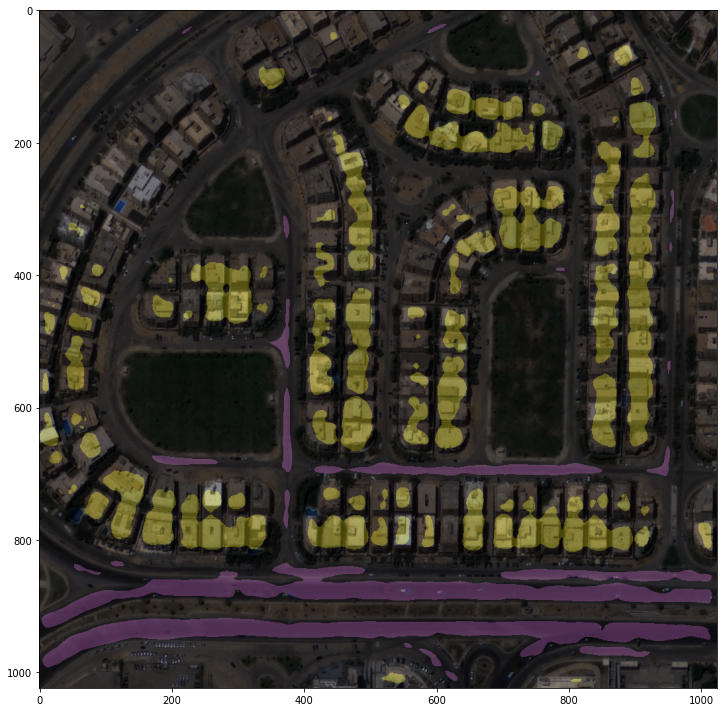

In [34]:
checkpoint_file = '/content/drive/MyDrive/SIA/semantic_checkpoint/iter_4000.pth'  #학습된 모델

# checkpoint 저장된 model 파일을 이용하여 모델을 생성, 이때 Config는 위에서 update된 config 사용. 
model_ckpt = init_segmentor(cfg, checkpoint_file, device='cuda:0')  #cuda gpu 사용

img = mmcv.imread('/content/drive/MyDrive/SIA/images/BLD00049_PS3_K3A_NIA0276.png')
result = inference_segmentor(model_ckpt, img)
show_result_pyplot(model_ckpt, img, result, palette)

/content/mmsegmentation/mmseg/models/backbones/resnet.py:431: UserWarning: DeprecationWarning: pretrained is a deprecated, please use "init_cfg" instead
  warnings.warn('DeprecationWarning: pretrained is a deprecated, '
/content/mmsegmentation/mmseg/models/losses/cross_entropy_loss.py:233: UserWarning: Default ``avg_non_ignore`` is False, if you would like to ignore the certain label and average loss over non-ignore labels, which is the same with PyTorch official cross_entropy, set ``avg_non_ignore=True``.
  'Default ``avg_non_ignore`` is False, if you would like to '


load checkpoint from local path: /content/drive/MyDrive/SIA/semantic_checkpoint/iter_13000.pth


/content/mmsegmentation/mmseg/models/segmentors/base.py:289: UserWarning: show==False and out_file is not specified, only result image will be returned
  warnings.warn('show==False and out_file is not specified, only '


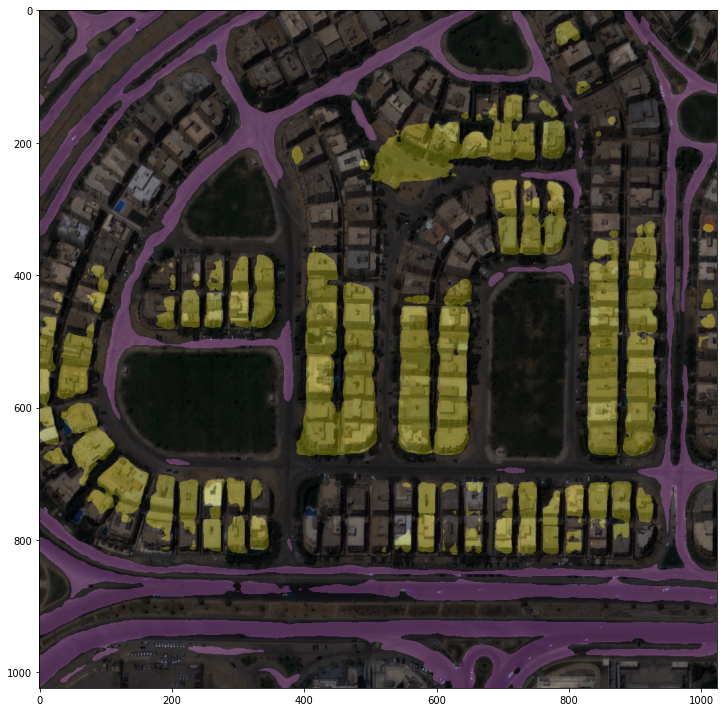

In [22]:
checkpoint_file = '/content/drive/MyDrive/SIA/semantic_checkpoint/iter_13000.pth'  #학습된 모델

# checkpoint 저장된 model 파일을 이용하여 모델을 생성, 이때 Config는 위에서 update된 config 사용. 
model_ckpt = init_segmentor(cfg, checkpoint_file, device='cuda:0')  #cuda gpu 사용

img = mmcv.imread('/content/drive/MyDrive/SIA/images/BLD00049_PS3_K3A_NIA0276.png')
result = inference_segmentor(model_ckpt, img)
show_result_pyplot(model_ckpt, img, result, palette)

/content/mmsegmentation/mmseg/models/backbones/resnet.py:431: UserWarning: DeprecationWarning: pretrained is a deprecated, please use "init_cfg" instead
  warnings.warn('DeprecationWarning: pretrained is a deprecated, '
/content/mmsegmentation/mmseg/models/losses/cross_entropy_loss.py:233: UserWarning: Default ``avg_non_ignore`` is False, if you would like to ignore the certain label and average loss over non-ignore labels, which is the same with PyTorch official cross_entropy, set ``avg_non_ignore=True``.
  'Default ``avg_non_ignore`` is False, if you would like to '


load checkpoint from local path: /content/drive/MyDrive/SIA/semantic_checkpoint/iter_3000.pth


/content/mmsegmentation/mmseg/models/segmentors/base.py:289: UserWarning: show==False and out_file is not specified, only result image will be returned
  warnings.warn('show==False and out_file is not specified, only '


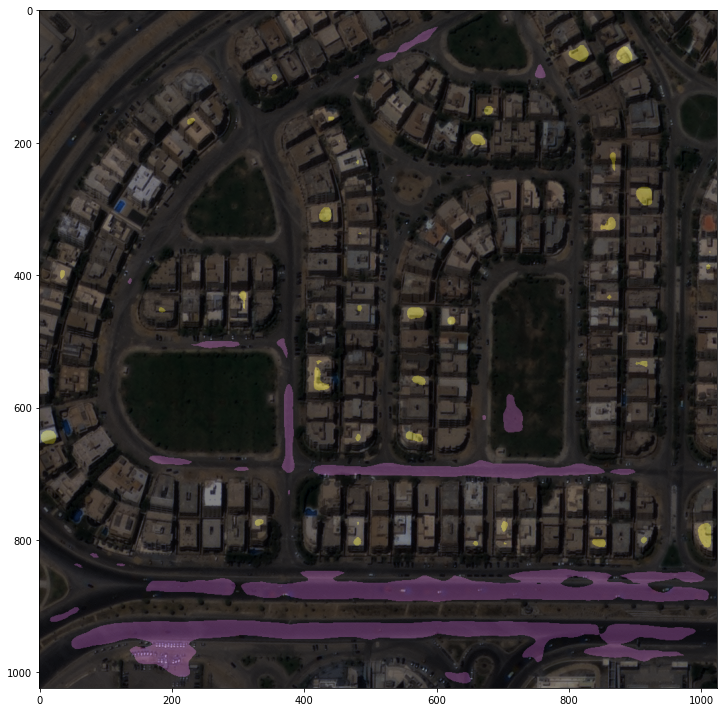

In [23]:
checkpoint_file = '/content/drive/MyDrive/SIA/semantic_checkpoint/iter_3000.pth'  #학습된 모델

# checkpoint 저장된 model 파일을 이용하여 모델을 생성, 이때 Config는 위에서 update된 config 사용. 
model_ckpt = init_segmentor(cfg, checkpoint_file, device='cuda:0')  #cuda gpu 사용

img = mmcv.imread('/content/drive/MyDrive/SIA/images/BLD00049_PS3_K3A_NIA0276.png')
result = inference_segmentor(model_ckpt, img)
show_result_pyplot(model_ckpt, img, result, palette)

/content/mmsegmentation/mmseg/models/backbones/resnet.py:431: UserWarning: DeprecationWarning: pretrained is a deprecated, please use "init_cfg" instead
  warnings.warn('DeprecationWarning: pretrained is a deprecated, '
/content/mmsegmentation/mmseg/models/losses/cross_entropy_loss.py:233: UserWarning: Default ``avg_non_ignore`` is False, if you would like to ignore the certain label and average loss over non-ignore labels, which is the same with PyTorch official cross_entropy, set ``avg_non_ignore=True``.
  'Default ``avg_non_ignore`` is False, if you would like to '


load checkpoint from local path: /content/drive/MyDrive/SIA/semantic_checkpoint/iter_4000.pth


/content/mmsegmentation/mmseg/models/segmentors/base.py:289: UserWarning: show==False and out_file is not specified, only result image will be returned
  warnings.warn('show==False and out_file is not specified, only '


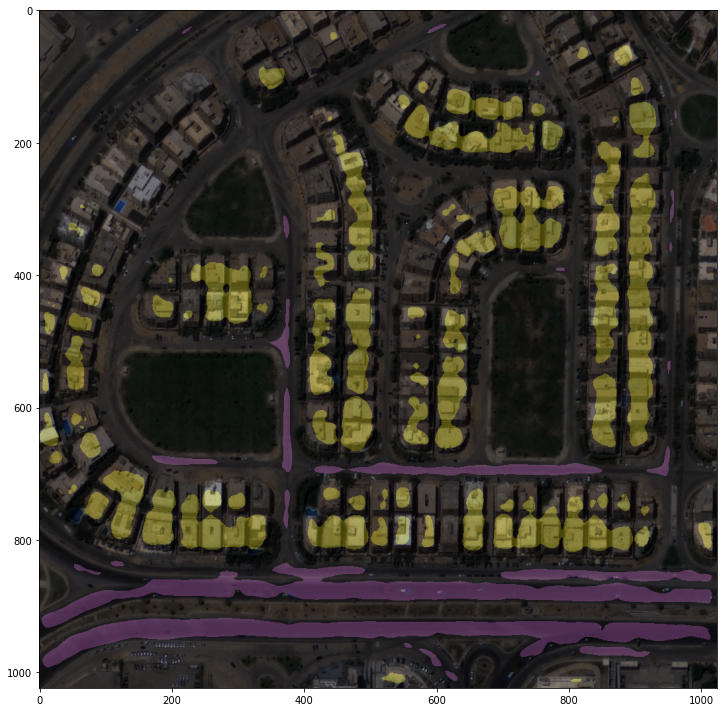

In [24]:
checkpoint_file = '/content/drive/MyDrive/SIA/semantic_checkpoint/iter_4000.pth'  #학습된 모델

# checkpoint 저장된 model 파일을 이용하여 모델을 생성, 이때 Config는 위에서 update된 config 사용. 
model_ckpt = init_segmentor(cfg, checkpoint_file, device='cuda:0')  #cuda gpu 사용

img = mmcv.imread('/content/drive/MyDrive/SIA/images/BLD00049_PS3_K3A_NIA0276.png')
result = inference_segmentor(model_ckpt, img)
show_result_pyplot(model_ckpt, img, result, palette)

/content/mmsegmentation/mmseg/models/backbones/resnet.py:431: UserWarning: DeprecationWarning: pretrained is a deprecated, please use "init_cfg" instead
  warnings.warn('DeprecationWarning: pretrained is a deprecated, '
/content/mmsegmentation/mmseg/models/losses/cross_entropy_loss.py:233: UserWarning: Default ``avg_non_ignore`` is False, if you would like to ignore the certain label and average loss over non-ignore labels, which is the same with PyTorch official cross_entropy, set ``avg_non_ignore=True``.
  'Default ``avg_non_ignore`` is False, if you would like to '


load checkpoint from local path: /content/drive/MyDrive/SIA/semantic_checkpoint/iter_5000.pth


/content/mmsegmentation/mmseg/models/segmentors/base.py:289: UserWarning: show==False and out_file is not specified, only result image will be returned
  warnings.warn('show==False and out_file is not specified, only '


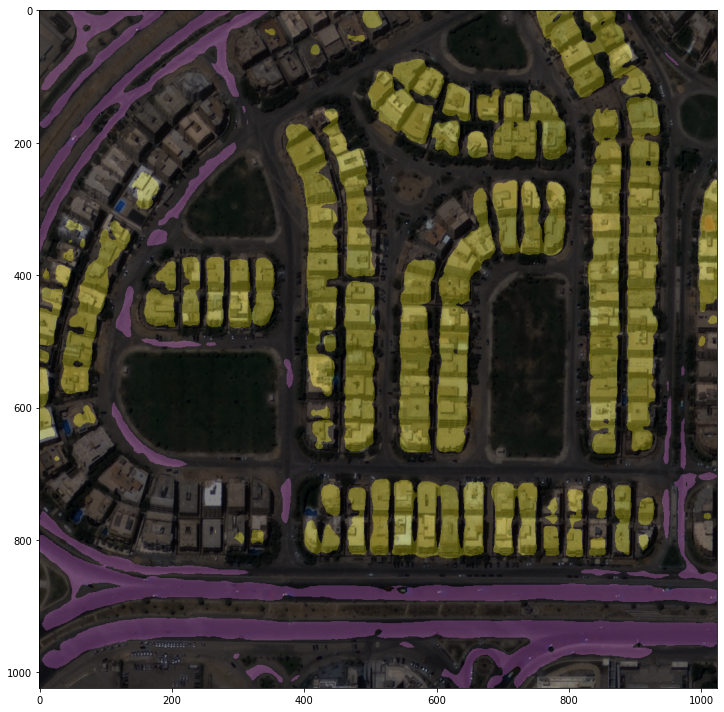

In [25]:
checkpoint_file = '/content/drive/MyDrive/SIA/semantic_checkpoint/iter_5000.pth'  #학습된 모델

# checkpoint 저장된 model 파일을 이용하여 모델을 생성, 이때 Config는 위에서 update된 config 사용. 
model_ckpt = init_segmentor(cfg, checkpoint_file, device='cuda:0')  #cuda gpu 사용

img = mmcv.imread('/content/drive/MyDrive/SIA/images/BLD00049_PS3_K3A_NIA0276.png')
result = inference_segmentor(model_ckpt, img)
show_result_pyplot(model_ckpt, img, result, palette)

In [28]:
print(1)

1
